In [1]:
import pandas as pd, numpy as np
from vivarium import Artifact

from pathlib import Path

from math import floor

import matplotlib.pyplot as plt

import pdb

In [2]:
FORECASTED_POP_KEY = "population.structure"
SCALING_FACTOR_KEY = "population.scaling_factor"
ACMR_KEY = "cause.all_causes.cause_specific_mortality_rate"
CSMR_KEY = "cause.alzheimers_disease_and_other_dementias.cause_specific_mortality_rate"
BBBM_INCIDENCE_KEY = "cause.alzheimers.susceptible_to_bbbm_transition_count"
TIME_STEP_YEARS = 1
GBD_AGE_GROUP_YEARS = 5
TIME_STEPS_PER_AGE_GROUP = GBD_AGE_GROUP_YEARS / TIME_STEP_YEARS

SIM_START = 2023
SIM_END = 2100

In [3]:
def load_artifact(location, artifacts_dir):
    art_filename = f"{location.lower().replace(' ', '_')}.hdf"
    return Artifact(Path(artifacts_dir) / art_filename)

In [4]:
def initialize_pop_table(location, artifacts_dir):
    art = load_artifact(location, artifacts_dir)
    forecasted_pop = (
        art.load(FORECASTED_POP_KEY)
        .query("year_start == 2021 & age_start >=60 & age_start<80")
        .mean(axis=1)
        .droplevel(["location", "year_start", "year_end"])
    )
    all_states_prev = (
        art.load(SCALING_FACTOR_KEY)
        .query("age_start >=60 & age_start<80")  # only 2023 data
        .mean(axis=1)
        .droplevel(["year_start", "year_end"])
    )
    groups = forecasted_pop * (1 - all_states_prev)
    # build table with rows where age_end - age_start = time step (1 year)
    table = pd.Series(
        index=pd.MultiIndex.from_tuples([], names=list(groups.index.names))
    )
    for index, value in groups.items():
        (sex, age_start, age_end) = index
        while age_start < age_end:
            table.loc[(sex, age_start, age_start + 1)] = (
                value / TIME_STEPS_PER_AGE_GROUP
            )  # divide GBD age groups evenly (TBD - how does engineering do this?)
            age_start += 1
    return table

In [5]:
location = "United States of America"
artifacts_dir = (
    "/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model7.0"
)
# population table of people in location ages 60-80 who do not have pre-clinical, MCI or AD
pop_table = initialize_pop_table(location, artifacts_dir)
pop_table

sex     age_start  age_end
Female  60.0       61.0       2.200912e+06
        61.0       62.0       2.200912e+06
        62.0       63.0       2.200912e+06
        63.0       64.0       2.200912e+06
        64.0       65.0       2.200912e+06
        65.0       66.0       1.924770e+06
        66.0       67.0       1.924770e+06
        67.0       68.0       1.924770e+06
        68.0       69.0       1.924770e+06
        69.0       70.0       1.924770e+06
        70.0       71.0       1.585602e+06
        71.0       72.0       1.585602e+06
        72.0       73.0       1.585602e+06
        73.0       74.0       1.585602e+06
        74.0       75.0       1.585602e+06
        75.0       76.0       1.003150e+06
        76.0       77.0       1.003150e+06
        77.0       78.0       1.003150e+06
        78.0       79.0       1.003150e+06
        79.0       80.0       1.003150e+06
Male    60.0       61.0       2.049056e+06
        61.0       62.0       2.049056e+06
        62.0       63.0    

In [6]:
def get_prev_table_index(cur_index):
    (sex, age_start, age_end) = cur_index
    return (sex, age_start - TIME_STEP_YEARS, age_end - TIME_STEP_YEARS)

In [32]:
def run_time_step(pop_table, year, new_entrants, bbbm_incidence, mortality):
    person_time = dict({"year": year})
    person_time["deaths"] = 0
    person_time["exits_to_sim"] = 0
    person_time["incidence"] = 0
    for index, _ in pop_table.iloc[::-1].items():  # iterate in reverse order
        (sex, age_start, _) = index
        prev_index = get_prev_table_index(index)
        lookup_year = min(year, 2050)

        if age_start == 60:  # add incident 60 year olds:
            pop_table.loc[index] = new_entrants.loc[(sex, lookup_year)]
            person_time["incidence"] += pop_table.loc[index]
        else:  # copy population from the age group below this one
            # move people into new age groups:
            pop_table.loc[index] = pop_table.loc[prev_index]

            # mortality:
            age_group_start = (
                floor((age_start - 1) / GBD_AGE_GROUP_YEARS) * GBD_AGE_GROUP_YEARS
            )  # previous age_start

            index_in_groups = (
                sex,
                age_group_start,
                age_group_start + 5,
                lookup_year,
                lookup_year + 1,
            )
            person_time["deaths"] += (
                pop_table.loc[index] * mortality.loc[index_in_groups]
            )
            pop_table.loc[index] *= 1 - mortality.loc[index_in_groups]

            # remove people entering sim (incident to pre-clinical):
            person_time["exits_to_sim"] += (
                bbbm_incidence.loc[index_in_groups] / GBD_AGE_GROUP_YEARS
            )
            pop_table.loc[index] -= (
                bbbm_incidence.loc[index_in_groups] / GBD_AGE_GROUP_YEARS
            )

        person_time[age_start] = pop_table.loc[index]
    return person_time

In [8]:
def load_background_mortality():
    # copied from loader.py
    art = load_artifact(location, artifacts_dir)
    acmr = art.load(ACMR_KEY)
    csmr = art.load(CSMR_KEY).droplevel(["year_start", "year_end"])

    # for now, assume csmr is the same for all years based on docs
    csmr_all_years = pd.DataFrame(csmr, index=acmr.index)
    return (
        (acmr - csmr_all_years).query("age_start >= 60 & age_start < 80").mean(axis=1)
    )

In [37]:
# calculate 60 to 61 year olds who are not in simulation for each forecast year
art = load_artifact(location, artifacts_dir)
new_entrants_forecasted = (
    art.load(FORECASTED_POP_KEY)
    .query("age_start == 60")
    .mean(axis=1)
    .droplevel(["location", "age_start", "age_end", "year_end"])
)
new_entrants_all_states_prev = (
    art.load(SCALING_FACTOR_KEY)
    .query("age_start == 60")  # only 2023 data
    .mean(axis=1)
    .droplevel(["age_start", "age_end", "year_start", "year_end"])
)
new_entrants = new_entrants_forecasted * (1 - new_entrants_all_states_prev) / 5

background_mortality = load_background_mortality()

bbbm_incidence_counts = (
    art.load(BBBM_INCIDENCE_KEY).query("age_start >= 60 & age_start < 80").mean(axis=1)
)

# person-time observer
person_time = []


for year in range(SIM_START, SIM_END):
    year_person_time = run_time_step(
        pop_table, year, new_entrants, bbbm_incidence_counts, background_mortality
    )
    person_time.append(year_person_time)


age_groups = (
    pd.DataFrame(person_time)
    .drop(["deaths", "exits_to_sim", "incidence"], axis=1)
    .set_index("year")
)
age_groups = age_groups[age_groups.columns[::-1]]  # reverse order
categories = pd.DataFrame(person_time)[
    ["year", "deaths", "exits_to_sim", "incidence"]
].set_index("year")
display(age_groups)
display(categories)

,60.0,61.0,62.0,63.0,64.0,65.0,66.0,67.0,68.0,69.0,70.0,71.0,72.0,73.0,74.0,75.0,76.0,77.0,78.0,79.0
year,,,,,,,,,,,,,,,,,,,,
2023,2.192240e+06,2.166068e+06,2.145840e+06,2.125744e+06,2.105780e+06,2.085945e+06,2.053085e+06,2.022198e+06,1.991595e+06,1.961273e+06,1.931228e+06,1.882654e+06,1.833510e+06,1.785095e+06,1.737397e+06,1.690406e+06,1.625767e+06,1.556355e+06,1.488713e+06,1.422794e+06
2024,2.175253e+06,2.168849e+06,2.142877e+06,2.122803e+06,2.102860e+06,2.083047e+06,2.050041e+06,2.017531e+06,1.986975e+06,1.956699e+06,1.926701e+06,1.878170e+06,1.830418e+06,1.782107e+06,1.734512e+06,1.687621e+06,1.622168e+06,1.559314e+06,1.491818e+06,1.426042e+06
2025,2.154591e+06,2.152200e+06,2.145845e+06,2.120068e+06,2.100145e+06,2.080353e+06,2.047240e+06,2.014583e+06,1.982417e+06,1.952184e+06,1.922228e+06,1.873744e+06,1.826027e+06,1.779075e+06,1.731574e+06,1.684776e+06,1.618627e+06,1.554967e+06,1.493835e+06,1.428188e+06
2026,2.134268e+06,2.131895e+06,2.129522e+06,2.123215e+06,2.097630e+06,2.077856e+06,2.044672e+06,2.011906e+06,1.979591e+06,1.947761e+06,1.917845e+06,1.869283e+06,1.821604e+06,1.774679e+06,1.728507e+06,1.681794e+06,1.615143e+06,1.550795e+06,1.488869e+06,1.429402e+06
2027,2.113515e+06,2.111947e+06,2.109592e+06,2.107237e+06,2.100976e+06,2.075580e+06,2.042427e+06,2.009586e+06,1.977159e+06,1.945178e+06,1.913678e+06,1.864905e+06,1.817141e+06,1.770244e+06,1.724090e+06,1.678676e+06,1.611915e+06,1.547064e+06,1.484454e+06,1.424200e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2095,2.189612e+06,2.169228e+06,2.148977e+06,2.128858e+06,2.108870e+06,2.089014e+06,2.057790e+06,2.026853e+06,1.996199e+06,1.965827e+06,1.935732e+06,1.885735e+06,1.836479e+06,1.787952e+06,1.740144e+06,1.693044e+06,1.621649e+06,1.552074e+06,1.484273e+06,1.418199e+06
2096,2.189612e+06,2.169228e+06,2.148977e+06,2.128858e+06,2.108870e+06,2.089014e+06,2.057790e+06,2.026853e+06,1.996199e+06,1.965827e+06,1.935732e+06,1.885735e+06,1.836479e+06,1.787952e+06,1.740144e+06,1.693044e+06,1.621649e+06,1.552074e+06,1.484273e+06,1.418199e+06
2097,2.189612e+06,2.169228e+06,2.148977e+06,2.128858e+06,2.108870e+06,2.089014e+06,2.057790e+06,2.026853e+06,1.996199e+06,1.965827e+06,1.935732e+06,1.885735e+06,1.836479e+06,1.787952e+06,1.740144e+06,1.693044e+06,1.621649e+06,1.552074e+06,1.484273e+06,1.418199e+06


,deaths,exits_to_sim,incidence
year,,,
2023,1.267362e+06,431365.451534,4.234455e+06
2024,1.250747e+06,443768.870363,4.203143e+06
2025,1.232295e+06,454511.537073,4.164627e+06
2026,1.215190e+06,464070.151703,4.126538e+06
2027,1.195659e+06,471642.012910,4.087525e+06
...,...,...,...
2095,1.051514e+06,478440.607285,4.230451e+06
2096,1.051514e+06,478440.607285,4.230451e+06
2097,1.051514e+06,478440.607285,4.230451e+06


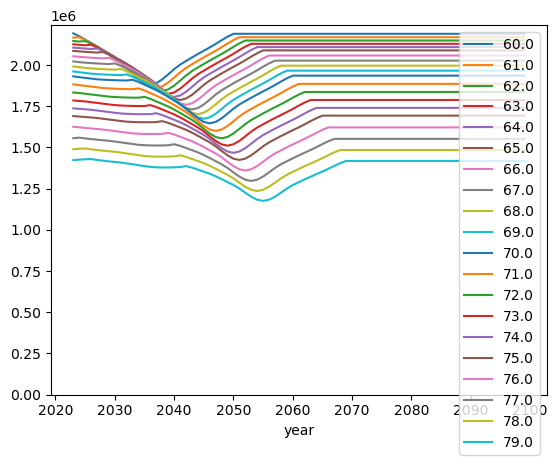

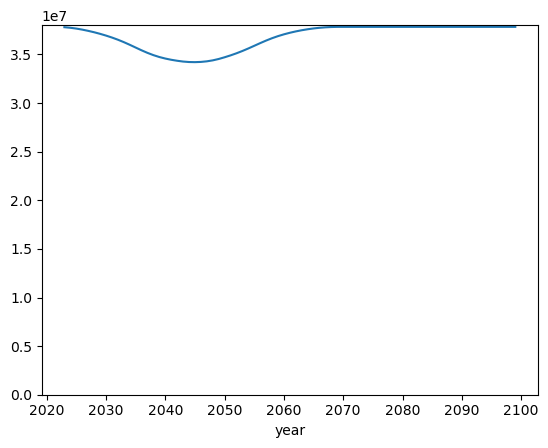

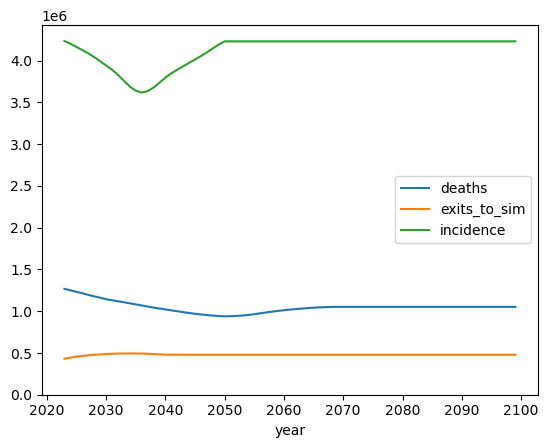

In [40]:
age_groups.plot()
plt.ylim(bottom=0)
plt.show()
age_groups.sum(axis=1).plot()
plt.ylim(bottom=0)
plt.show()
categories.plot()
plt.ylim(bottom=0)
plt.show()